In [1]:
using Distributions
using Random
using PyPlot
using SpecialFunctions

In [2]:
using StatsFuns

In [3]:
init_α(K) = rand(Uniform(0, 100), K)
init_λ(a, b, K) = rand(Gamma(a, 1/b), K)
init_p(α) = rand(Dirichlet(α))

init_p (generic function with 1 method)

In [4]:
mutable struct PriorParameters
    a::AbstractVector
    b::AbstractVector
    α::AbstractVector
    PriorParameters() = new()
    PriorParameters(a, b, α) = new(a, b, α)
end

mutable struct PoissionMixtureModel
    model::MixtureModel{Univariate,Discrete,Poisson,Float64}
    λs::AbstractMatrix
    ps::AbstractMatrix
    loglikelihoods::AbstractVector
    PoissionMixtureModel() = new()
end

In [5]:
function init_model(;K::Int = 3, a = 1.0, b = 0.01)
    α = init_α(K)
    λ = init_λ(a, b, K)
    p = init_p(α)
    prior = PriorParameters(ones(K) .* a, ones(K) .*b, α)
    prior, MixtureModel(Poisson, λ, p)
end

function generate_toy_data(
        N::Int = 10^4;
        true_λ::AbstractVector = [100., 50., 15.],
        true_p::AbstractVector = [0.5, 0.2, 0.3]
    )
    true_data = MixtureModel(Poisson, true_λ, true_p)
    toy_data = rand(true_data, N)
    true_data, toy_data
end

generate_toy_data (generic function with 2 methods)

In [6]:
N = 10^3
maxiter = 1000

a = 1.
b = 0.01
N = 2000
true_λ = [100., 50., 15.]
true_p = [0.5, 0.2, 0.3]
true_model, toy_data = generate_toy_data(N)
prior, model = init_model(a = a, b = b)

(PriorParameters([1.0, 1.0, 1.0], [0.01, 0.01, 0.01], [14.54813342936443, 62.14951368703776, 64.67463631647776]), MixtureModel{Poisson}(K = 3)
components[1] (prior = 0.1154): Poisson{Float64}(λ=248.19363623611744)
components[2] (prior = 0.3881): Poisson{Float64}(λ=264.27632883135584)
components[3] (prior = 0.4965): Poisson{Float64}(λ=52.633831880064804)
)

In [7]:
function update_s(prior, data)
    N = length(data)
    K = length(prior.α)
    
    η = Matrix{Float64}(undef, N, K)
    
    a = prior.a
    b = prior.b
    α = prior.α
    λ = a ./ b
    lnλ = digamma.(a) .- digamma.(b)
    lnp = [digamma(α[k]) + digamma(sum(α)) for k = 1:K]
    
    @inbounds for n = 1:N
        @simd for k = 1:K
            η[n, k] = data[n]*lnλ[k] - λ[k] + lnp[k]
        end
        logsum_η = -logsumexp(η[n, :])
        @simd for k = 1:K
            η[n, k] = exp(η[n, k] + logsum_η)
        end
    end
    η
end

update_s (generic function with 1 method)

In [8]:
function update_λ(prior, η, toy_data)
    K = size(η, 2)
    â = Vector{Float64}(undef, K)
    b̂ = Vector{Float64}(undef, K)
    a = prior.a
    b = prior.b
    @inbounds for k = 1:K
        â[k] = sum(η[:, k] .* toy_data) + a[k]
        b̂[k] = sum(η[:, k]) + b[k]
    end
    â, b̂
end

update_λ (generic function with 1 method)

In [9]:
function update_p(prior, η)
    N, K = size(η)
    α̂ = Vector{Float64}(undef, K)
    α = prior.α
    @inbounds for k = 1:K
        α̂[k] = sum(η[:, k]) + α[k]
    end
    α̂
end

update_p (generic function with 1 method)

In [10]:
function vi!(
        prior::PriorParameters,
        toy_data::AbstractVector;
        maxiter::Int = 2000
    )
    N = length(toy_data)
    K = length(prior.α)
    
    elbo = Vector{Float64}(undef, N)
    elbo[1] = 
    @inbounds for i = 1:maxiter

        η = update_s(prior, toy_data)
        â, b̂ = update_λ(prior, η, toy_data)
        α̂ = update_p(prior, η)
    
        prior.a = â
        prior.b = b̂
        prior.α = α̂
    end
    prior
end

vi! (generic function with 1 method)

In [69]:
x = rand(3)

3-element Array{Float64,1}:
 0.983402939510257
 0.2178826219604948
 0.20565179496329788

In [71]:
x*x'

3×3 Array{Float64,2}:
 0.967081  0.214266   0.202239
 0.214266  0.0474728  0.044808
 0.202239  0.044808   0.0422927

In [ ]:
function ELBO(prior::PriorParameters)

In [66]:
a = 1.
b = 0.01
N = 20000
true_λ = [100., 50., 15.]
true_p = [0.5, 0.2, 0.3]
true_model, toy_data = generate_toy_data(N)
prior, model = init_model(a = a, b = b)

vi!(prior, toy_data, maxiter=2000)

PriorParameters([1.855058218721073e8, 2.0038910203847303e9, 3.9253716074316305e8], [1.2126352581768258e7, 2.0037437796117697e7, 7.836209652114021e6], [1.212643383459785e7, 2.003744387045816e7, 7.836276510921592e6])

mean(alpha[k, :]) = 0.30315967103405606
mean(lambda[k]) = 15.29780225826073
mean(alpha[k, :]) = 0.5009353619179082
mean(lambda[k]) = 100.00720691374215

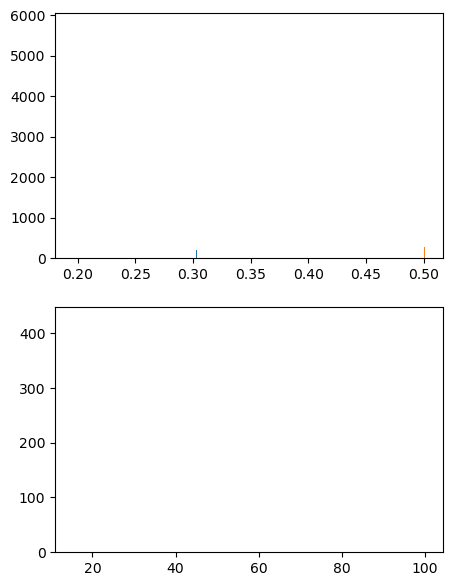


mean(alpha[k, :]) = 0.19590496704803567
mean(lambda[k]) = 50.092824326228566


In [67]:
fig, ax = plt.subplots(2, 1, figsize=(5, 7))

alpha = rand(Dirichlet(prior.α), 10000)
lambda = [rand(Gamma(prior.a[k], 1/prior.b[k]), 100) for k = 1:3]
for k = 1:3
    ax[1].hist(alpha[k, :], density=1)
    ax[2].hist(lambda[k], density=1)
end